# Station Clustering (Winter 2018, weekday)
This notebook uses K-means clustering with PCA to group stations into 3 and 4 different clusters. 

The station features are the total hourly 'Activity' and 'Flux' where: 

    Activity = num_pickups + num_dropoffs

    Flux = num_pickups - num_dropoffs

In [1]:
%matplotlib inline 
#%matplotlib inline notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import requests
import math
from matplotlib import cm

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

Start by loading in all of the dataframes and then restrict to weekday trips

In [2]:
###
subs_df = pd.read_pickle('../../data/pickledDFs/subs_df-NYC_Winter_2018.pkl')
stations_info_df = pd.read_pickle('../../data/pickledDFs/stations_info_df-NYC_Winter_2018.pkl')
subs_trips_df = pd.read_pickle('../../data/pickledDFs/subs_trips_df-NYC_Winter_2018.pkl')
###

In [3]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()

`stations_info_df` has info on all stations used in the full winter dataset, this may include stations not in `weekday_subs_trips_df` so the following checks that and removes any extra stations 

In [4]:
station_drops = []
WD_unique = np.unique(np.concatenate((weekday_subs_trips_df['start station id'].unique(),weekday_subs_trips_df['end station id'].unique())))

for ind in stations_info_df.index:
    if not (ind in WD_unique):
        station_drops.append(ind)
        
print(station_drops)

stations_info_df.drop(station_drops,inplace=True)
len(stations_info_df) == len(WD_unique)

[]


True

Compute total hourly pickups and dropoffs for each station and pivot into a more readable form

In [5]:
WD_puhour_groupby = weekday_subs_trips_df.groupby(['start station id', 'pickup_hour'])
WD_puhour_df = WD_puhour_groupby.count()['tripduration'].rename('NumPickups').reset_index(1).pivot(columns = 'pickup_hour').fillna(0)

WD_dohour_groupby = weekday_subs_trips_df.groupby(['end station id', 'dropoff_hour'])
WD_dohour_df = WD_dohour_groupby.count()['tripduration'].rename('NumDropoffs').reset_index(1).pivot(columns = 'dropoff_hour').fillna(0)


In [6]:
WD_puhour_df.head()

NumPickups                                                \
pickup_hour              0    1    2    3    4     5     6      7      8    
start station id                                                            
72                     14.0  5.0  9.0  3.0  4.0  44.0  62.0  160.0  347.0   
79                     12.0  8.0  5.0  0.0  1.0  44.0  37.0   67.0  243.0   
82                      6.0  2.0  0.0  0.0  0.0   4.0  19.0   40.0   68.0   
83                     13.0  9.0  2.0  2.0  0.0   0.0  46.0   21.0   57.0   
119                     1.0  1.0  3.0  0.0  0.0   1.0  13.0   29.0   78.0   

                         ...                                             \
pickup_hour          9   ...      14     15     16     17     18     19   
start station id         ...                                              
72                411.0  ...   155.0  194.0  265.0  404.0  344.0  274.0   
79                187.0  ...   163.0  163.0  223.0  279.0  433.0  264.0   
82                113.0  ...    89.0   79.0   64.0  105.0  114.0   76.0   
83                 52.0  ...    72.0   94.0   71.0  153.0  235.0  146.0   
119                42.0  ...    71.0   24.0   35.0   50.0   40.0   18.0   

                                            
pickup_hour          20     21    22    23  
start station id                            
72                143.0   65.0  44.0  37.0  
79                134.0  128.0  59.0  35.0  
82                 62.0   53.0  18.0  11.0  
83                114.0  122.0  81.0  53.0  
119                18.0    3.0   2.0   1.0  

[5 rows x 24 columns]

Concatenate the pickup and dropoff dataframes into one

In [22]:
WD_counts_df = pd.concat([WD_puhour_df,WD_dohour_df],axis=1).fillna(0)
WD_counts_df['total_pickups'] = WD_counts_df['NumPickups'].sum(axis=1)
WD_counts_df['total_dropoffs'] = WD_counts_df['NumDropoffs'].sum(axis=1)

In [23]:
for num in range(24):
    WD_counts_df['Activity',num] =  WD_counts_df['NumPickups',num] + WD_counts_df['NumDropoffs',num]
    WD_counts_df['Flux',num] =  WD_counts_df['NumPickups',num] - WD_counts_df['NumDropoffs',num]

WD_counts_df['total_counts'] = WD_counts_df['Activity'].sum(axis=1)
WD_counts_df.drop(['NumPickups','NumDropoffs'],axis=1,inplace=True)

In [24]:
WD_counts_df.sort_values('total_counts',ascending=False).head()

total_pickups total_dropoffs Activity  Flux Activity  Flux  \
pickup_hour                                     0     0        1     1   
519               24660.0        24823.0    167.0 -19.0     71.0  19.0   
3255              14371.0        14825.0     79.0  -3.0     65.0  -3.0   
402               13706.0        14582.0     65.0   3.0     32.0   4.0   
435               13083.0        13347.0     79.0  11.0     29.0  -5.0   
490               12730.0        13159.0    172.0 -36.0     78.0 -32.0   

            Activity  Flux Activity Flux     ...             Activity   Flux  \
pickup_hour        2     2        3    3     ...          19       20     20   
519             11.0   5.0      8.0  4.0     ...       654.0   1480.0  232.0   
3255            51.0 -31.0     16.0 -4.0     ...      -123.0    551.0  -13.0   
402             26.0 -12.0     10.0  8.0     ...       758.0    700.0  216.0   
435             10.0  -6.0     13.0 -5.0     ...       218.0   1071.0   19.0   
490             27.0  11.0     41.0 -1.0     ...         9.0    838.0   66.0   

            Activity   Flux Activity   Flux Activity  Flux total_counts  
pickup_hour       21     21       22     22       23    23               
519            776.0   50.0    438.0   62.0    205.0  35.0      49483.0  
3255           434.0  -10.0    336.0   28.0    196.0 -28.0      29196.0  
402            388.0   82.0    259.0   61.0    106.0  28.0      28288.0  
435            714.0   18.0    248.0   24.0    178.0   4.0      26430.0  
490            640.0  192.0    572.0  140.0    227.0  69.0      25889.0  

[5 rows x 51 columns]

In [25]:
# What's the most popular station?
stations_info_df.loc[519] #This is Grand Central Station

lat                           40.7519
lon                          -73.9777
station name    Pershing Square North
Name: 519, dtype: object

Define some plotting functions

In [37]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import seaborn as sns; sns.set()
def color_st(x):
    sns.set_color_codes()
    if x == 0:
        return 'b'
    elif x == 1:
        return 'orange'
    elif x == 2:
        return 'g'
    elif x == 3:
        return 'r'
    elif x == 4:
        return 'purple'
    elif x == 5:
        return 'm'
    elif x == 6:
        return 'c'
    elif x == 7:
        return 'y'
    

#Imported/modified from UMICH coursera course, a simple scatter plot function
def plot_labelled_scatter(X, y, class_labels, pca_vars = (0,1)):
    num_labels = len(class_labels)
    y_ser = pd.Series(y)

    x_min, x_max = X[:, pca_vars[0]].min() - 1, X[:, pca_vars[0]].max() + 1
    y_min, y_max = X[:, pca_vars[1]].min() - 1, X[:, pca_vars[1]].max() + 1

    marker_array = ['o', '^', '*']
    color_array = [color_st(num) for num in range(0,num_labels)]
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()
    
    
    plt.scatter(X[:, pca_vars[0]], X[:, pca_vars[1]], s=65, color=y_ser.map(lambda x: color_st(x)), norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    ax = plt.gca()
    ax.set_xlabel('1st PC')
    ax.set_ylabel('2nd PC')
    
    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_st(c), label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()
    
def plot_3d_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)
    y_ser = pd.Series(y)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1

    marker_array = ['o', '^', '*']
    color_array = [color_st(num) for num in range(0,num_labels)]
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.scatter(X[:, 0], X[:, 1],X[:, 2], s=65, color=y_ser.map(lambda x: color_st(x)), norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_st(c), label=class_labels[c]))
    plt.legend(handles=h)
    plt.legend()
    

Finally import `tilemapbase` and setup some parameters for plotting maps

In [27]:
import tilemapbase
tilemapbase.start_logging()

In [28]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [29]:
t = tilemapbase.tiles.Carto_Light

In [30]:
hour_mark_loc = (-74.02,40.77)
x_cen, y_cen = tilemapbase.project(*hour_mark_loc)

stations = [tilemapbase.project(x,y) for x,y in zip(stations_info_df['lon'], stations_info_df['lat'])]
x, y = zip(*stations)

# Clustering with Activity and Flux (3 clusters)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

First, do some PCA to simplify our feature space

In [42]:
WD_counts_df[['Activity','Flux']].head()

Activity                                                          \
pickup_hour       0     1     2    3    4     5      6      7      8      9    
72              28.0   9.0  12.0  5.0  6.0  54.0  182.0  350.0  589.0  867.0   
79              16.0  13.0  10.0  0.0  8.0  55.0  107.0  189.0  568.0  640.0   
82              18.0   6.0   2.0  3.0  1.0   7.0   27.0   73.0  173.0  191.0   
83              16.0  13.0   3.0  2.0  2.0  16.0  131.0  171.0  316.0  296.0   
119              3.0   1.0   4.0  1.0  0.0   1.0  130.0   41.0  121.0   58.0   

             ...   Flux                                                    \
pickup_hour  ...     14    15    16     17     18    19    20    21    22   
72           ...   -8.0  17.0  41.0  143.0  -83.0  23.0   1.0 -40.0 -54.0   
79           ...   19.0  32.0  30.0   47.0  186.0  88.0  31.0  70.0  15.0   
82           ...   17.0  36.0  12.0   10.0  -20.0 -26.0 -24.0  -8.0 -13.0   
83           ...    1.0  15.0 -36.0   44.0  111.0  27.0  58.0  95.0  53.0   
119          ...   30.0 -11.0 -14.0   -9.0  -10.0 -23.0 -11.0 -23.0 -21.0   

                   
pickup_hour    23  
72            9.0  
79            5.0  
82          -15.0  
83           34.0  
119          -6.0  

[5 rows x 48 columns]

In [32]:
X = WD_counts_df[['Activity','Flux']].values

X_normalized = StandardScaler().fit(X).transform(X)

#Only compute the first two PCA components, going to higher order starts to be sensitive to local (hourly) structure of data
pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(777, 48) (777, 2)


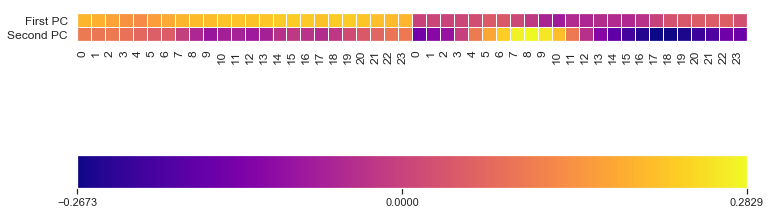

In [33]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')

plt.gca().set_xticks(np.arange(-.5, 48))
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(list(range(24))+list(range(24)), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.35);

In [34]:
print('First PC mean norm and std dev of hourly activity coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[0][:24]).mean(),np.absolute(pca.components_[0][:24]).std()))
print('First PC mean norm and std dev of hourly flux coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[0][24:]).mean(),np.absolute(pca.components_[0][24:]).std()))

print('Second PC mean norm and std dev of hourly activity coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[1][:24]).mean(),np.absolute(pca.components_[1][:24]).std()))
print('Second PC mean norm and std dev hourly flux coefficient: {:.3f}, {:.3f}'.format(np.absolute(pca.components_[1][24:]).mean(),np.absolute(pca.components_[1][24:]).std()))


First PC mean norm and std dev of hourly activity coefficient: 0.199, 0.025
First PC mean norm and std dev of hourly flux coefficient: 0.033, 0.020
Second PC mean norm and std dev of hourly activity coefficient: 0.060, 0.028
Second PC mean norm and std dev hourly flux coefficient: 0.177, 0.076


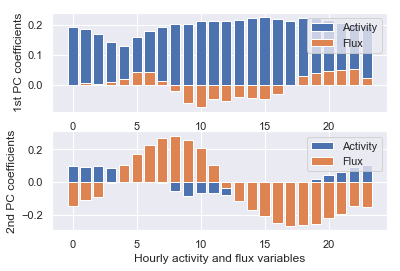

In [35]:
#Another visualization of the PCA components
fig,ax = plt.subplots(2)

ax[0].bar(range(24),pca.components_[0][:24])
ax[0].bar(range(24),pca.components_[0][24:])
ax[0].set_xlabel('Hourly activity and flux variables')
ax[0].set_ylabel('1st PC coefficients')

ax[0].legend(['Activity','Flux'])

ax[1].bar(range(24),pca.components_[1][:24])
ax[1].bar(range(24),pca.components_[1][24:])
ax[1].set_xlabel('Hourly activity and flux variables')
ax[1].set_ylabel('2nd PC coefficients')

ax[1].legend(['Activity','Flux']);

Next, do Kmeans clustering with 3 clusters

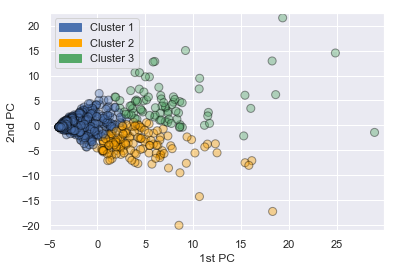

In [41]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3)
kmeans.fit(X_pca)

WD_counts_df['Kmeans_label'] = kmeans.labels_

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3'])



## Some visualizations

Now that we have grouped the stations into clusters, let's try plotting the hourly flux and activity, aggregated over the instances of each cluster

We will start with the flux:

In [54]:
flux_df=WD_counts_df[['Flux','Kmeans_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
flux_melt_df = flux_df.iloc[0:24].melt('hour', var_name='station', value_name='flux')
flux_melt_df['Kmeans_label']=flux_melt_df['station'].map(lambda x: flux_df.iloc[24][x])

In [55]:
flux_melt_df['Kmeans_label']=flux_melt_df['Kmeans_label'].astype(int)

In [56]:
flux_melt_df.head()

hour station  flux  Kmeans_label
0    0      72   0.0             0
1    1      72   1.0             0
2    2      72   6.0             0
3    3      72   1.0             0
4    4      72   2.0             0

Aggregated hourly flux

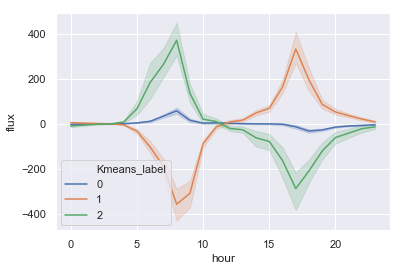

In [57]:
sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="flux", hue = 'Kmeans_label', palette = sns.color_palette(n_colors=3),data=flux_melt_df)

Now, showing each individual station

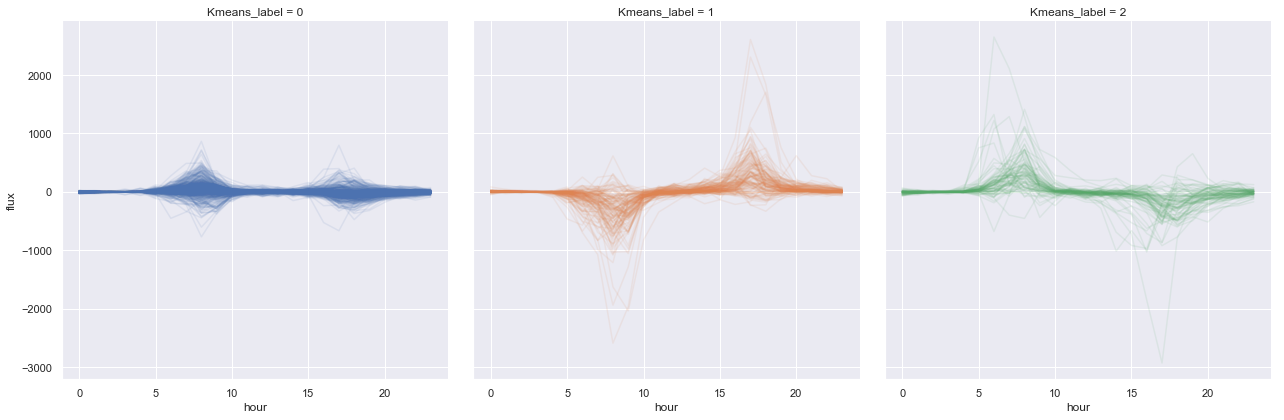

In [58]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_melt_df,col='Kmeans_label',hue='Kmeans_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

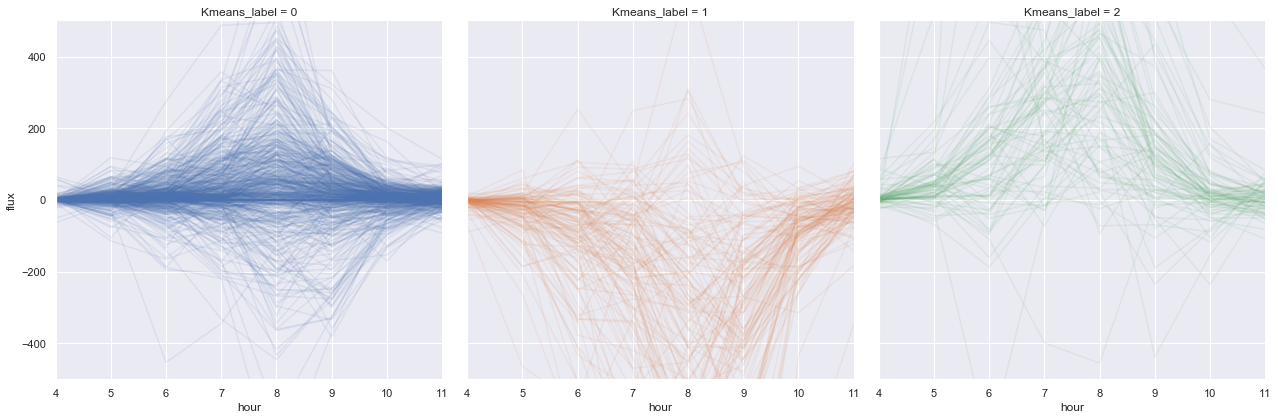

In [59]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_melt_df,col='Kmeans_label',hue='Kmeans_label', height=6,col_wrap=3)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-500, top=500);
ax.set_xlim(left=4,right=11);

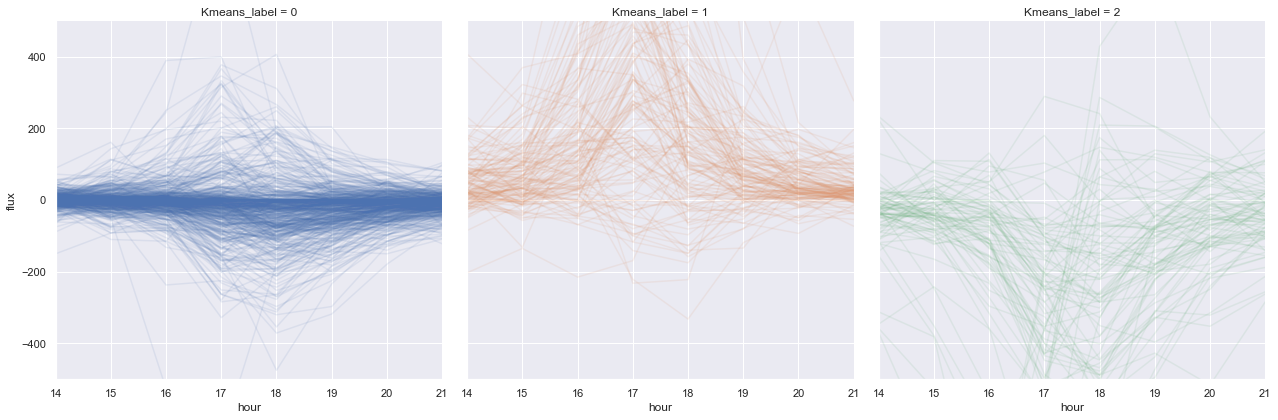

In [60]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_melt_df,col='Kmeans_label',hue='Kmeans_label', height=6,col_wrap = 3)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-500, top=500);
ax.set_xlim(left=14,right=21);

Plotting Activity

In [61]:
activity_df=WD_counts_df[['Activity','Kmeans_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
activity_melt_df = activity_df.iloc[0:24].melt('hour', var_name='station', value_name='activity')
activity_melt_df['Kmeans_label']=activity_melt_df['station'].map(lambda x: activity_df.iloc[24][x])

In [62]:
activity_melt_df['Kmeans_label']=activity_melt_df['Kmeans_label'].astype(int)

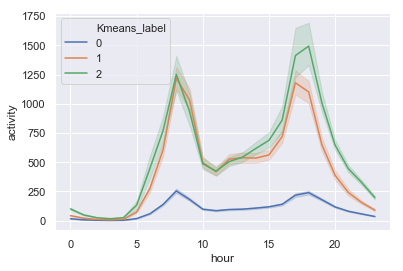

In [63]:
sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="activity", hue = 'Kmeans_label', palette = sns.color_palette(n_colors=3),data=activity_melt_df)

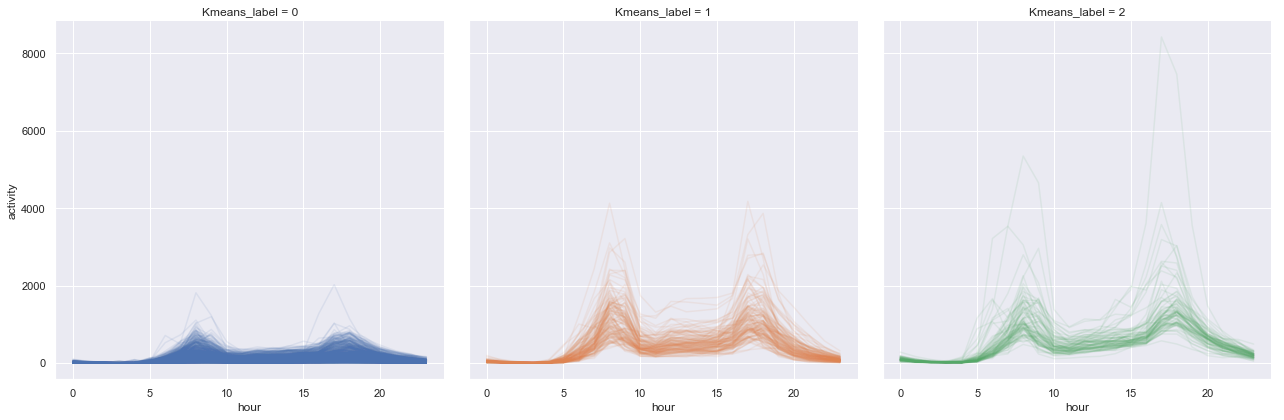

In [64]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(activity_melt_df,col='Kmeans_label',hue='Kmeans_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','activity', estimator = None, units='station',alpha=.1)

Finally, let's put all of this together and plot a station location map as a scatter plot overlayed on a map of NYC, where we set the colors to be assigned by the Kmeans label

In [65]:
stations_info_df['Kmeans_label'] = WD_counts_df['Kmeans_label']
stations_info_df['color'] = stations_info_df['Kmeans_label'].map(lambda x: color_st(x))

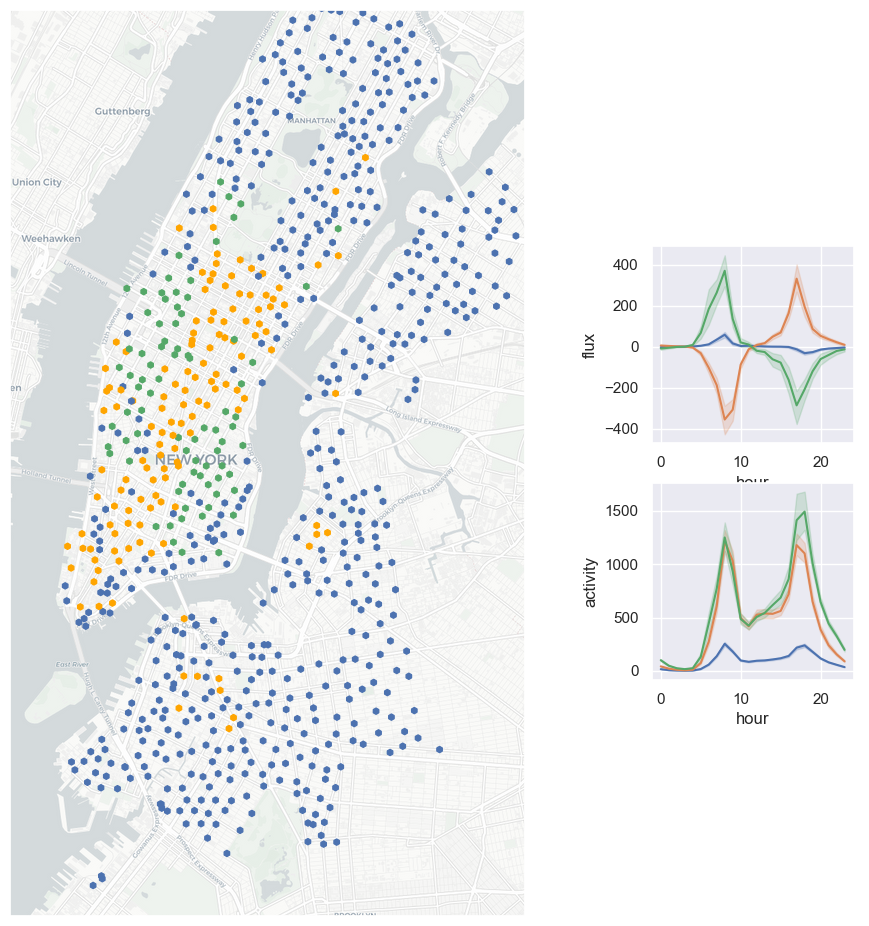

In [66]:
#fig, ax = plt.subplots(figsize=(12,12), dpi=100)
fig = plt.subplots(figsize=(12,12),dpi=100)
    
ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=4,colspan=3)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax1, t)

ax1.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)#, animated=True);

ax2 =  plt.subplot2grid((4, 4), (1, 3))
sns.lineplot(x="hour", y="flux", hue = 'Kmeans_label', palette = sns.color_palette(n_colors = 3), data=flux_melt_df,legend=False)


ax3 =  plt.subplot2grid((4, 4), (2, 3))
sns.lineplot(x="hour", y="activity", hue = 'Kmeans_label', palette = sns.color_palette(n_colors = 3), data=activity_melt_df,legend=False)

For some final bits of information, here we just output the total number of stations for each label, followed by the total counts for each station category:
* 0: blue
* 1: orange
* 2: green

In [67]:
for num in range(len(np.unique(kmeans.labels_))):
    print('Kmeans_label {}: {}'.format(num,len(WD_counts_df[WD_counts_df['Kmeans_label'] == num])))

Kmeans_label 0: 564
Kmeans_label 1: 133
Kmeans_label 2: 80


In [68]:
#This gives me a performance issue warning because I have some multi-index columns which I am dropping
WD_counts_df.groupby('Kmeans_label').sum()['total_counts']

C:\Users\pgsze\Anaconda3\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Kmeans_label
0    1328861.0
1    1449468.0
2    1072267.0
Name: total_counts, dtype: float64

## Now using 4 clusters

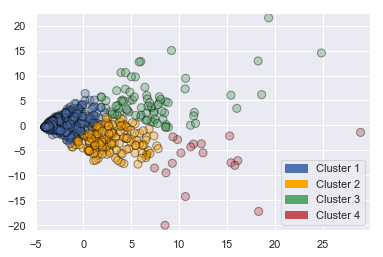

In [86]:
kmeans4 = KMeans(n_clusters = 4)
kmeans4.fit(X_pca)

plot_labelled_scatter(X_pca, kmeans4.labels_, 
                      ['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4'])

In [87]:
WD_counts_df['Kmeans4_label'] = kmeans4.labels_

Plotting Flux

In [88]:
flux_4cluster_df=WD_counts_df[['Flux','Kmeans4_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
flux_4cluster_melt_df = flux_4cluster_df.iloc[0:24].melt('hour', var_name='station', value_name='flux')
flux_4cluster_melt_df['Kmeans4_label']=flux_4cluster_melt_df['station'].map(lambda x: flux_4cluster_df.iloc[24][x])

In [89]:
flux_4cluster_melt_df['Kmeans4_label']=flux_4cluster_melt_df['Kmeans4_label'].astype(int)

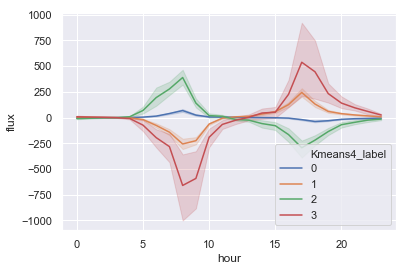

In [90]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
sns.color_palette()

ax = sns.lineplot(x="hour", y="flux", hue = 'Kmeans4_label', palette = sns.color_palette(n_colors = 4), data=flux_4cluster_melt_df)

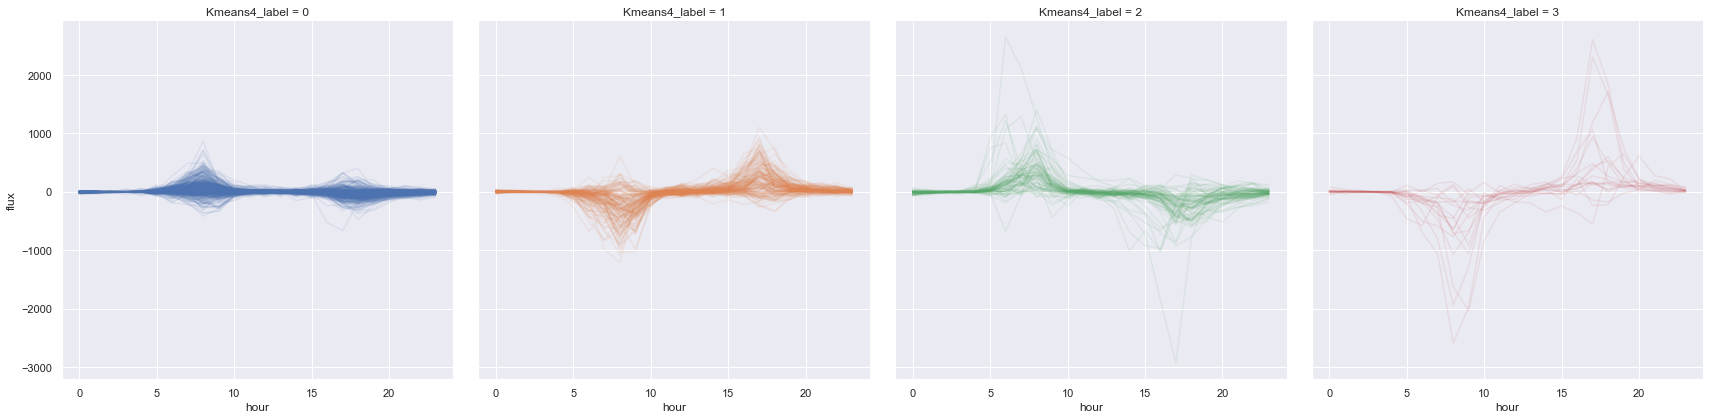

In [91]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap = 4)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

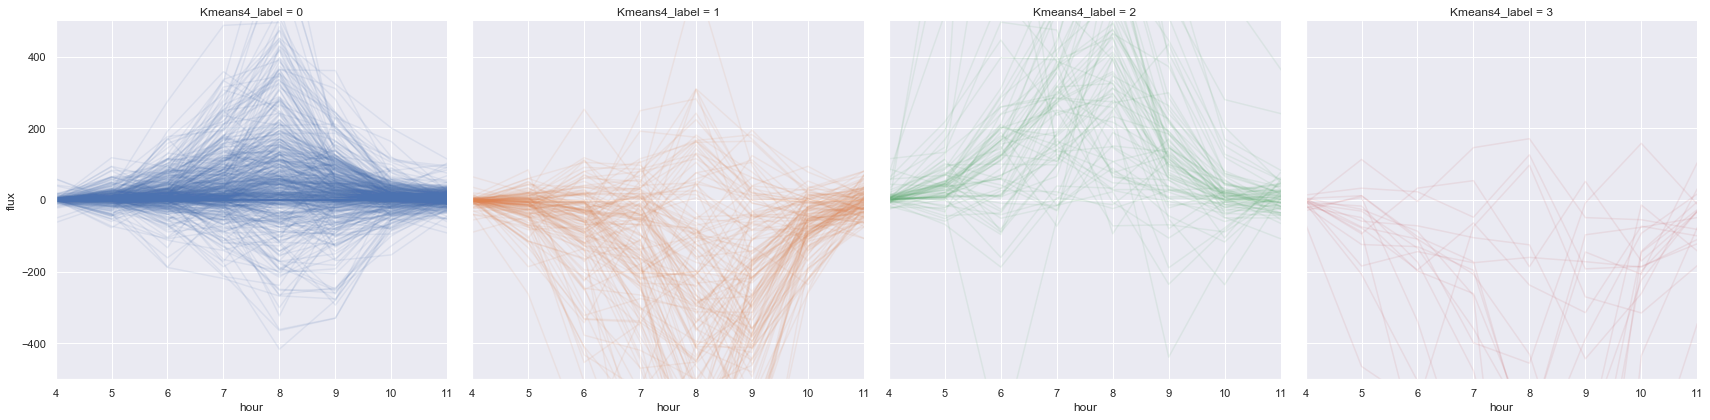

In [92]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap = 4)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-500, top=500);
ax.set_xlim(left=4,right=11);

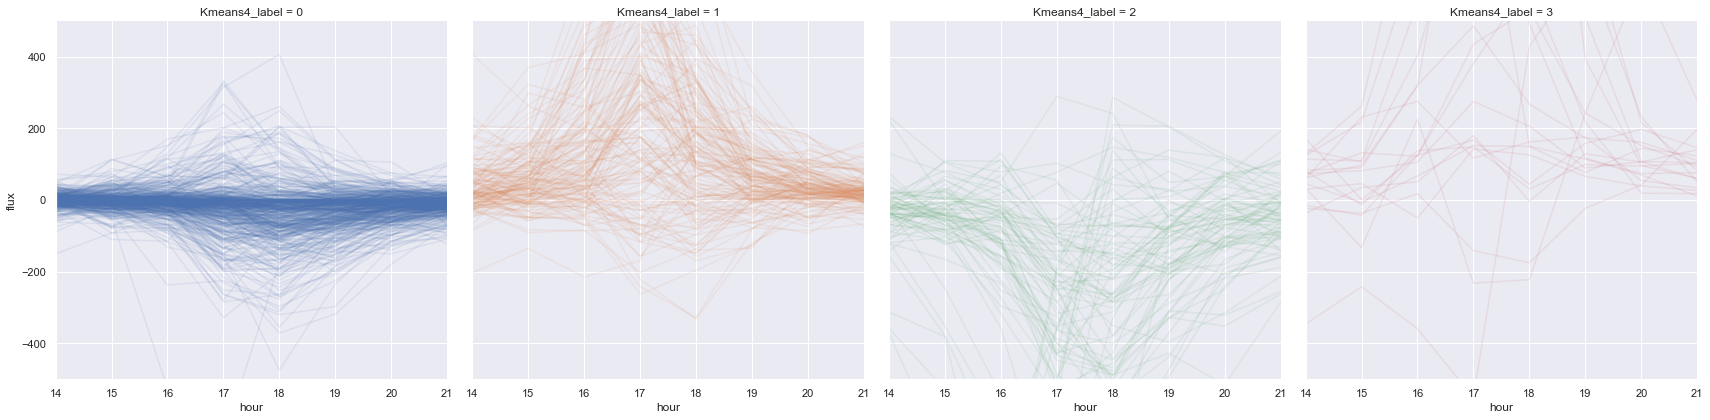

In [93]:
sns.set(font_scale=1)

g = sns.FacetGrid(flux_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap = 4)
g = g.map_dataframe(sns.lineplot, 'hour','flux', estimator = None, units='station',alpha=.1)

ax=plt.gca()
ax.set_ylim(bottom=-500, top=500);
ax.set_xlim(left=14,right=21);

Plotting Activity

In [94]:
activity_4cluster_df=WD_counts_df[['Activity','Kmeans4_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
activity_4cluster_melt_df = activity_4cluster_df.iloc[0:24].melt('hour', var_name='station', value_name='activity')
activity_4cluster_melt_df['Kmeans4_label']=activity_4cluster_melt_df['station'].map(lambda x: activity_4cluster_df.iloc[24][x])

In [95]:
activity_4cluster_melt_df['Kmeans4_label']=activity_4cluster_melt_df['Kmeans4_label'].astype(int)

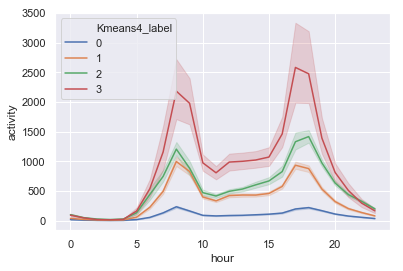

In [96]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="activity", hue = 'Kmeans4_label', palette= sns.color_palette(n_colors=4), data=activity_4cluster_melt_df)


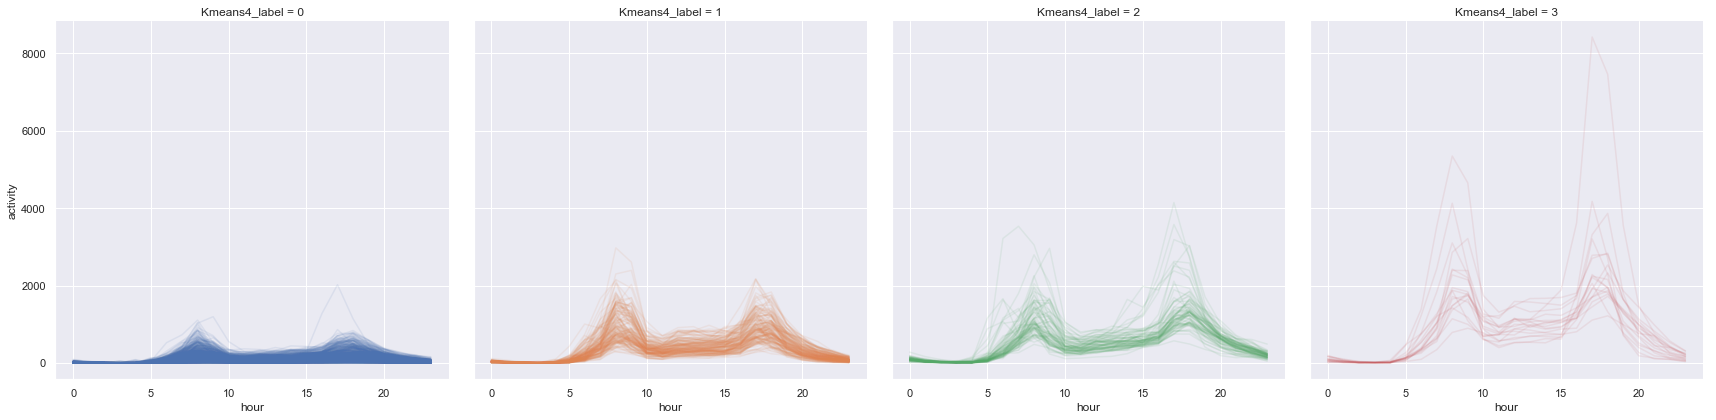

In [97]:
#Plot all stations
sns.set(font_scale=1)

g = sns.FacetGrid(activity_4cluster_melt_df,col='Kmeans4_label',hue='Kmeans4_label', height=6,col_wrap=4)
g = g.map_dataframe(sns.lineplot, 'hour','activity', estimator = None, units='station',alpha=.1)

In [98]:
stations_info_df['Kmeans4_label'] = WD_counts_df['Kmeans4_label']
stations_info_df['color4'] = stations_info_df['Kmeans4_label'].map(lambda x: color_st(x))

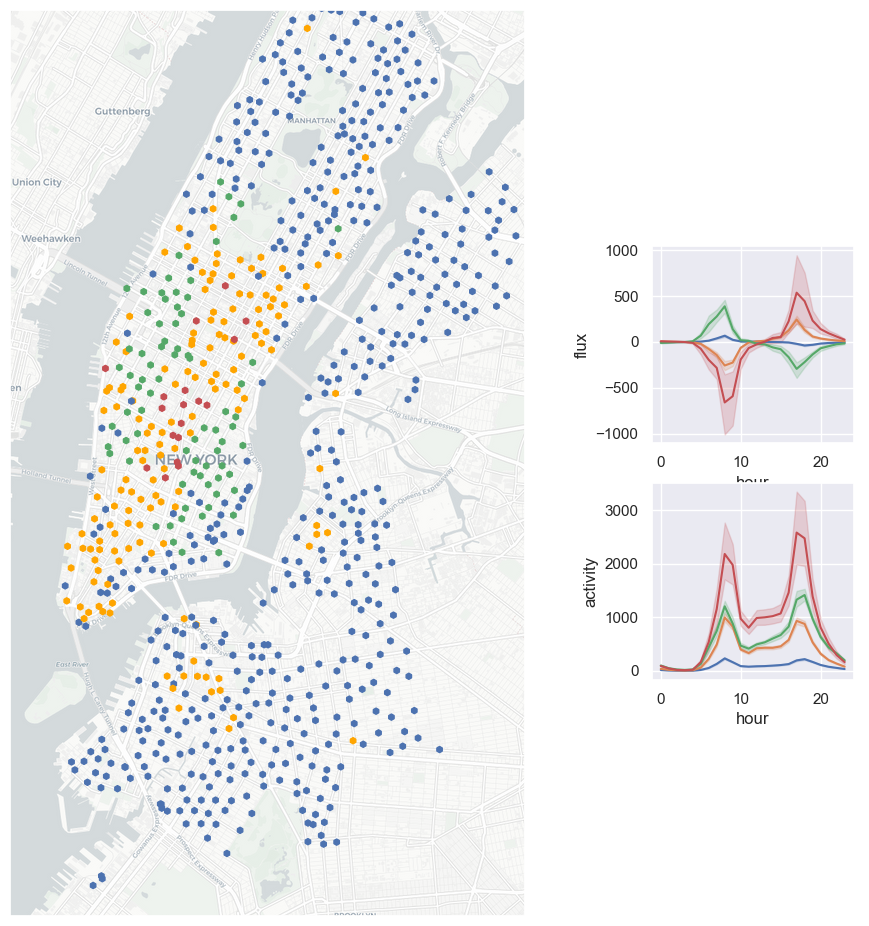

In [99]:
#fig, ax = plt.subplots(figsize=(12,12), dpi=100)
fig = plt.subplots(figsize=(12,12),dpi=100)
    
ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=4,colspan=3)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax1, t)

ax1.scatter(x,y, marker = 'h', color = stations_info_df['color4'], alpha = 1, s = 20)#, animated=True);

ax2 =  plt.subplot2grid((4, 4), (1, 3))
sns.lineplot(x="hour", y="flux", hue = 'Kmeans4_label', palette = sns.color_palette(n_colors = 4), data=flux_4cluster_melt_df,legend=False)


ax3 =  plt.subplot2grid((4, 4), (2, 3))
sns.lineplot(x="hour", y="activity", hue = 'Kmeans4_label', palette = sns.color_palette(n_colors = 4), data=activity_4cluster_melt_df,legend=False)

In [100]:
for num in range(len(np.unique(kmeans4.labels_))):
    print('Kmeans4_label {}: {}'.format(num,len(WD_counts_df[WD_counts_df['Kmeans4_label'] == num])))

Kmeans4_label 0: 531
Kmeans4_label 1: 152
Kmeans4_label 2: 76
Kmeans4_label 3: 18


In [102]:
#This gives me a performance issue warning because I have some multi-index columns which I am dropping
WD_counts_df.groupby('Kmeans4_label').sum()['total_counts']

Kmeans4_label
0    1139514.0
1    1336771.0
2     982895.0
3     391416.0
Name: total_counts, dtype: float64